In [1]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader
from torchvision import transforms
from einops import rearrange
import matplotlib.pyplot as plt
import optuna
import numpy as np

# 数据加载和预处理
image_path = './'
transform = transforms.Compose([transforms.ToTensor()]) 

mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)

mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path,
                                                train=False,
                                                transform=transform,
                                                download=False)

batch_size = 128
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)



C:\Users\Clearlove\.conda\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

#残差模块，放在每个前馈网络和注意力之后，缓解梯度消失问题，并允许更深的网络
class Residual(nn.Module): # 通过连接层或者补充，保证fn输出和x是同维度的
    def __init__(self, fn): # 带function参数的Module，都是嵌套的Module
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x 


#layernorm归一化,放在多头注意力层和激活函数层。用绝对位置编码的BERT，layernorm用来自身通道归一化
class PreNorm(nn.Module): # 先归一化，再用function作用。
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim) # 三维的用dim
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


#放置多头注意力后，因为在于多头注意力使用的矩阵乘法为线性变换，后面跟上由全连接网络构成的FeedForward增加非线性结构
class FeedForward(nn.Module): # 非线性前馈，保持dim维不变
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)


#多头注意力层，多个自注意力连起来。使用qkv计算
class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, mask=None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        # (batch_size, seq_len, 3 * dim)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h)
        # q, k, v=(3, batch_size, heads, seq_len, dim // heads)
        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
        # dot =(batch_size, heads, seq_len, seq_len)
        if mask is not None:
            # 填充掩码，使其尺寸与注意力得分的尺寸匹配
            mask = F.pad(mask.flatten(1), (1, 0), value=True) 
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            # 将二维的掩码扩展为三维，以匹配注意力分数的形状
            # 掩码中的每个True值都会扩展为一个二维的True矩阵，表示对应位置之间的注意力分数不应被忽略。
            mask = mask[:, None, :] * mask[:, :, None]
            # 将掩码中为False的位置在注意力分数矩阵中对应的值设置为负无穷,后续计算被忽略
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads=heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x


class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=1):
        super().__init__()
        #将图像切割成一个个图像块,组成序列化的数据输入Transformer执行图像分类任务。
        assert image_size % patch_size == 0, 'Image size must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2 # (P**2 C)：一个patch展平为向量后实际的长度

        self.patch_size = patch_size
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim)) # +1是为了适应cls_token
        self.patch_to_embedding = nn.Linear(patch_dim, dim) # 将patch_dim（原图）经过embedding后得到dim维的嵌入向量
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size
        
        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p) # 将H W C 转化成 N (P P C)
        x = self.patch_to_embedding(x) # 将(PPC)通过Embedding转化成一维embedding，这里的patch_to_embedding
        # 到这里，一张图片就和nlp里的一个句子以同样的形式输入Transformer中
        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1) 
        x = torch.cat((cls_tokens, x), dim=1) # 将类别信息接入embedding
        x += self.pos_embedding
        x = self.transformer(x, mask) # 送入encoder

        x = self.to_cls_token(x[:, 0]) # 取出class对应的token，用Identity占位
        return self.mlp_head(x) # 送入mlp分类器
        


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train(model, num_epochs, train_dl, valid_dl):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_accuracy = 0.0  # 初始化最佳准确率
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device)
                
                with torch.cuda.amp.autocast():
                    pred = model(x_batch)
                    loss = loss_fn(pred, y_batch)
                
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        # 如果验证准确率更高，则保存模型
        if accuracy_hist_valid[epoch] > best_accuracy:
            best_accuracy = accuracy_hist_valid[epoch]
            if trial is not None:
                trial.set_user_attr("best_model_state_dict", model.state_dict())
                trial.set_user_attr("best_accuracy", best_accuracy)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [4]:
def objective(trial):
    patch_size = trial.suggest_categorical('patch_size', [2, 4, 7, 14])
    dim = trial.suggest_int('dim', 64, 320, step=64)
    depth = trial.suggest_int('depth', 1, 6)
    mlp_dim = trial.suggest_int('mlp_dim', 128, 512, step=128)
    heads = trial.suggest_int('heads', 4, 8, step=4)

    model = ViT(
        image_size=28,
        patch_size=patch_size,
        num_classes=10,
        dim=dim,
        depth=depth,
        heads=heads,
        mlp_dim=mlp_dim,
        channels=1
    ).to(device)

    num_epochs = 15
    hist = train(model, num_epochs, train_dl, valid_dl)

    return max(hist[3])  # 返回验证集最高准确率

In [5]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 查找最佳trial
best_trial = study.best_trial
best_params = best_trial.params

# 保存最佳模型权重
torch.save(best_trial.user_attrs["best_model_state_dict"], "best_model.pth")

print(f"Best hyperparameters: {study.best_params}")
print(f"Best validation accuracy: {study.best_value:.4f}")

[I 2024-08-05 16:59:49,892] A new study created in memory with name: no-name-37b6c2a9-8eff-44a1-b999-dcfadd0f890c


Epoch 1 accuracy: 0.8309 val_accuracy: 0.9410
Epoch 2 accuracy: 0.9511 val_accuracy: 0.9590
Epoch 3 accuracy: 0.9657 val_accuracy: 0.9658
Epoch 4 accuracy: 0.9714 val_accuracy: 0.9726
Epoch 5 accuracy: 0.9755 val_accuracy: 0.9767
Epoch 6 accuracy: 0.9793 val_accuracy: 0.9735
Epoch 7 accuracy: 0.9815 val_accuracy: 0.9783
Epoch 8 accuracy: 0.9846 val_accuracy: 0.9757
Epoch 9 accuracy: 0.9849 val_accuracy: 0.9745
Epoch 10 accuracy: 0.9863 val_accuracy: 0.9776
Epoch 11 accuracy: 0.9884 val_accuracy: 0.9778
Epoch 12 accuracy: 0.9876 val_accuracy: 0.9794
Epoch 13 accuracy: 0.9913 val_accuracy: 0.9789
Epoch 14 accuracy: 0.9902 val_accuracy: 0.9751


[I 2024-08-05 17:04:01,040] Trial 0 finished with value: 0.9793999791145325 and parameters: {'patch_size': 14, 'dim': 64, 'depth': 4, 'mlp_dim': 128, 'heads': 4}. Best is trial 0 with value: 0.9793999791145325.


Epoch 15 accuracy: 0.9909 val_accuracy: 0.9766
Epoch 1 accuracy: 0.8485 val_accuracy: 0.9469
Epoch 2 accuracy: 0.9522 val_accuracy: 0.9598
Epoch 3 accuracy: 0.9645 val_accuracy: 0.9549
Epoch 4 accuracy: 0.9638 val_accuracy: 0.9681
Epoch 5 accuracy: 0.9660 val_accuracy: 0.9624
Epoch 6 accuracy: 0.9699 val_accuracy: 0.9685
Epoch 7 accuracy: 0.9723 val_accuracy: 0.9669
Epoch 8 accuracy: 0.9756 val_accuracy: 0.9698
Epoch 9 accuracy: 0.9756 val_accuracy: 0.9724
Epoch 10 accuracy: 0.9771 val_accuracy: 0.9711
Epoch 11 accuracy: 0.9777 val_accuracy: 0.9722
Epoch 12 accuracy: 0.9787 val_accuracy: 0.9737
Epoch 13 accuracy: 0.9816 val_accuracy: 0.9708
Epoch 14 accuracy: 0.9814 val_accuracy: 0.9723


[I 2024-08-05 17:12:44,450] Trial 1 finished with value: 0.9787999987602234 and parameters: {'patch_size': 7, 'dim': 320, 'depth': 6, 'mlp_dim': 384, 'heads': 8}. Best is trial 0 with value: 0.9793999791145325.


Epoch 15 accuracy: 0.9832 val_accuracy: 0.9788
Epoch 1 accuracy: 0.7307 val_accuracy: 0.9204
Epoch 2 accuracy: 0.9295 val_accuracy: 0.9430
Epoch 3 accuracy: 0.9462 val_accuracy: 0.9493
Epoch 4 accuracy: 0.9538 val_accuracy: 0.9588
Epoch 5 accuracy: 0.9608 val_accuracy: 0.9574
Epoch 6 accuracy: 0.9647 val_accuracy: 0.9620
Epoch 7 accuracy: 0.9660 val_accuracy: 0.9670
Epoch 8 accuracy: 0.9710 val_accuracy: 0.9638
Epoch 9 accuracy: 0.9730 val_accuracy: 0.9673
Epoch 10 accuracy: 0.9737 val_accuracy: 0.9693
Epoch 11 accuracy: 0.9757 val_accuracy: 0.9661
Epoch 12 accuracy: 0.9770 val_accuracy: 0.9710
Epoch 13 accuracy: 0.9773 val_accuracy: 0.9687
Epoch 14 accuracy: 0.9795 val_accuracy: 0.9685


[I 2024-08-05 17:21:54,878] Trial 2 finished with value: 0.9739000201225281 and parameters: {'patch_size': 2, 'dim': 256, 'depth': 2, 'mlp_dim': 128, 'heads': 8}. Best is trial 0 with value: 0.9793999791145325.


Epoch 15 accuracy: 0.9820 val_accuracy: 0.9739
Epoch 1 accuracy: 0.8238 val_accuracy: 0.9412
Epoch 2 accuracy: 0.9494 val_accuracy: 0.9525
Epoch 3 accuracy: 0.9590 val_accuracy: 0.9531
Epoch 4 accuracy: 0.9630 val_accuracy: 0.9687
Epoch 5 accuracy: 0.9674 val_accuracy: 0.9676
Epoch 6 accuracy: 0.9701 val_accuracy: 0.9618
Epoch 7 accuracy: 0.9718 val_accuracy: 0.9720
Epoch 8 accuracy: 0.9736 val_accuracy: 0.9674
Epoch 9 accuracy: 0.9774 val_accuracy: 0.9728
Epoch 10 accuracy: 0.9772 val_accuracy: 0.9747
Epoch 11 accuracy: 0.9772 val_accuracy: 0.9737
Epoch 12 accuracy: 0.9797 val_accuracy: 0.9736
Epoch 13 accuracy: 0.9805 val_accuracy: 0.9756
Epoch 14 accuracy: 0.9812 val_accuracy: 0.9784


[I 2024-08-05 17:26:27,339] Trial 3 finished with value: 0.9783999919891357 and parameters: {'patch_size': 4, 'dim': 320, 'depth': 3, 'mlp_dim': 256, 'heads': 8}. Best is trial 0 with value: 0.9793999791145325.


Epoch 15 accuracy: 0.9840 val_accuracy: 0.9760
Epoch 1 accuracy: 0.8503 val_accuracy: 0.9453
Epoch 2 accuracy: 0.9530 val_accuracy: 0.9654
Epoch 3 accuracy: 0.9651 val_accuracy: 0.9640
Epoch 4 accuracy: 0.9709 val_accuracy: 0.9742
Epoch 5 accuracy: 0.9759 val_accuracy: 0.9705
Epoch 6 accuracy: 0.9782 val_accuracy: 0.9745
Epoch 7 accuracy: 0.9805 val_accuracy: 0.9737
Epoch 8 accuracy: 0.9813 val_accuracy: 0.9771
Epoch 9 accuracy: 0.9833 val_accuracy: 0.9761
Epoch 10 accuracy: 0.9845 val_accuracy: 0.9763
Epoch 11 accuracy: 0.9848 val_accuracy: 0.9723
Epoch 12 accuracy: 0.9872 val_accuracy: 0.9769
Epoch 13 accuracy: 0.9871 val_accuracy: 0.9798
Epoch 14 accuracy: 0.9873 val_accuracy: 0.9782


[I 2024-08-05 17:30:19,927] Trial 4 finished with value: 0.9797999858856201 and parameters: {'patch_size': 14, 'dim': 128, 'depth': 3, 'mlp_dim': 128, 'heads': 4}. Best is trial 4 with value: 0.9797999858856201.


Epoch 15 accuracy: 0.9882 val_accuracy: 0.9742
Epoch 1 accuracy: 0.8086 val_accuracy: 0.9241
Epoch 2 accuracy: 0.9410 val_accuracy: 0.9444
Epoch 3 accuracy: 0.9558 val_accuracy: 0.9552
Epoch 4 accuracy: 0.9661 val_accuracy: 0.9646
Epoch 5 accuracy: 0.9705 val_accuracy: 0.9714
Epoch 6 accuracy: 0.9752 val_accuracy: 0.9740
Epoch 7 accuracy: 0.9774 val_accuracy: 0.9756
Epoch 8 accuracy: 0.9800 val_accuracy: 0.9720
Epoch 9 accuracy: 0.9828 val_accuracy: 0.9736
Epoch 10 accuracy: 0.9835 val_accuracy: 0.9759
Epoch 11 accuracy: 0.9860 val_accuracy: 0.9754
Epoch 12 accuracy: 0.9878 val_accuracy: 0.9774
Epoch 13 accuracy: 0.9871 val_accuracy: 0.9771
Epoch 14 accuracy: 0.9888 val_accuracy: 0.9802


[I 2024-08-05 17:33:27,248] Trial 5 finished with value: 0.9801999926567078 and parameters: {'patch_size': 14, 'dim': 64, 'depth': 1, 'mlp_dim': 512, 'heads': 8}. Best is trial 5 with value: 0.9801999926567078.


Epoch 15 accuracy: 0.9895 val_accuracy: 0.9755
Epoch 1 accuracy: 0.6744 val_accuracy: 0.8940
Epoch 2 accuracy: 0.9219 val_accuracy: 0.9433
Epoch 3 accuracy: 0.9513 val_accuracy: 0.9463
Epoch 4 accuracy: 0.9619 val_accuracy: 0.9610
Epoch 5 accuracy: 0.9686 val_accuracy: 0.9646
Epoch 6 accuracy: 0.9728 val_accuracy: 0.9690
Epoch 7 accuracy: 0.9760 val_accuracy: 0.9706
Epoch 8 accuracy: 0.9799 val_accuracy: 0.9693
Epoch 9 accuracy: 0.9810 val_accuracy: 0.9744
Epoch 10 accuracy: 0.9824 val_accuracy: 0.9710
Epoch 11 accuracy: 0.9846 val_accuracy: 0.9781
Epoch 12 accuracy: 0.9851 val_accuracy: 0.9645
Epoch 13 accuracy: 0.9867 val_accuracy: 0.9749
Epoch 14 accuracy: 0.9866 val_accuracy: 0.9775


[I 2024-08-05 17:37:17,047] Trial 6 finished with value: 0.9781000018119812 and parameters: {'patch_size': 4, 'dim': 64, 'depth': 3, 'mlp_dim': 384, 'heads': 4}. Best is trial 5 with value: 0.9801999926567078.


Epoch 15 accuracy: 0.9878 val_accuracy: 0.9686
Epoch 1 accuracy: 0.8119 val_accuracy: 0.9256
Epoch 2 accuracy: 0.9434 val_accuracy: 0.9479
Epoch 3 accuracy: 0.9580 val_accuracy: 0.9667
Epoch 4 accuracy: 0.9620 val_accuracy: 0.9630
Epoch 5 accuracy: 0.9687 val_accuracy: 0.9676
Epoch 6 accuracy: 0.9706 val_accuracy: 0.9674
Epoch 7 accuracy: 0.9722 val_accuracy: 0.9688
Epoch 8 accuracy: 0.9749 val_accuracy: 0.9709
Epoch 9 accuracy: 0.9779 val_accuracy: 0.9634
Epoch 10 accuracy: 0.9766 val_accuracy: 0.9699
Epoch 11 accuracy: 0.9802 val_accuracy: 0.9718
Epoch 12 accuracy: 0.9800 val_accuracy: 0.9690
Epoch 13 accuracy: 0.9805 val_accuracy: 0.9708
Epoch 14 accuracy: 0.9813 val_accuracy: 0.9701


[I 2024-08-05 17:41:01,801] Trial 7 finished with value: 0.9745000004768372 and parameters: {'patch_size': 4, 'dim': 256, 'depth': 2, 'mlp_dim': 128, 'heads': 8}. Best is trial 5 with value: 0.9801999926567078.


Epoch 15 accuracy: 0.9827 val_accuracy: 0.9745
Epoch 1 accuracy: 0.8481 val_accuracy: 0.9336
Epoch 2 accuracy: 0.9432 val_accuracy: 0.9597
Epoch 3 accuracy: 0.9531 val_accuracy: 0.9595
Epoch 4 accuracy: 0.9634 val_accuracy: 0.9645
Epoch 5 accuracy: 0.9649 val_accuracy: 0.9662
Epoch 6 accuracy: 0.9652 val_accuracy: 0.9704
Epoch 7 accuracy: 0.9721 val_accuracy: 0.9718
Epoch 8 accuracy: 0.9731 val_accuracy: 0.9711
Epoch 9 accuracy: 0.9750 val_accuracy: 0.9719
Epoch 10 accuracy: 0.9760 val_accuracy: 0.9723
Epoch 11 accuracy: 0.9753 val_accuracy: 0.9745
Epoch 12 accuracy: 0.9758 val_accuracy: 0.9713
Epoch 13 accuracy: 0.9782 val_accuracy: 0.9752
Epoch 14 accuracy: 0.9773 val_accuracy: 0.9632


[I 2024-08-05 17:45:17,947] Trial 8 finished with value: 0.9753000140190125 and parameters: {'patch_size': 14, 'dim': 320, 'depth': 3, 'mlp_dim': 128, 'heads': 4}. Best is trial 5 with value: 0.9801999926567078.


Epoch 15 accuracy: 0.9786 val_accuracy: 0.9753
Epoch 1 accuracy: 0.8227 val_accuracy: 0.9465
Epoch 2 accuracy: 0.9545 val_accuracy: 0.9541
Epoch 3 accuracy: 0.9652 val_accuracy: 0.9655
Epoch 4 accuracy: 0.9719 val_accuracy: 0.9679
Epoch 5 accuracy: 0.9768 val_accuracy: 0.9737
Epoch 6 accuracy: 0.9766 val_accuracy: 0.9702
Epoch 7 accuracy: 0.9784 val_accuracy: 0.9722
Epoch 8 accuracy: 0.9817 val_accuracy: 0.9750
Epoch 9 accuracy: 0.9806 val_accuracy: 0.9787
Epoch 10 accuracy: 0.9838 val_accuracy: 0.9743
Epoch 11 accuracy: 0.9830 val_accuracy: 0.9810
Epoch 12 accuracy: 0.9854 val_accuracy: 0.9777
Epoch 13 accuracy: 0.9865 val_accuracy: 0.9750
Epoch 14 accuracy: 0.9866 val_accuracy: 0.9807


[I 2024-08-05 17:49:33,058] Trial 9 finished with value: 0.9810000061988831 and parameters: {'patch_size': 7, 'dim': 192, 'depth': 4, 'mlp_dim': 512, 'heads': 8}. Best is trial 9 with value: 0.9810000061988831.


Epoch 15 accuracy: 0.9879 val_accuracy: 0.9789
Epoch 1 accuracy: 0.8192 val_accuracy: 0.9405
Epoch 2 accuracy: 0.9554 val_accuracy: 0.9664
Epoch 3 accuracy: 0.9666 val_accuracy: 0.9714
Epoch 4 accuracy: 0.9724 val_accuracy: 0.9693
Epoch 5 accuracy: 0.9768 val_accuracy: 0.9730
Epoch 6 accuracy: 0.9783 val_accuracy: 0.9707
Epoch 7 accuracy: 0.9815 val_accuracy: 0.9749
Epoch 8 accuracy: 0.9832 val_accuracy: 0.9732
Epoch 9 accuracy: 0.9810 val_accuracy: 0.9706
Epoch 10 accuracy: 0.9838 val_accuracy: 0.9761
Epoch 11 accuracy: 0.9836 val_accuracy: 0.9788
Epoch 12 accuracy: 0.9859 val_accuracy: 0.9773
Epoch 13 accuracy: 0.9858 val_accuracy: 0.9766
Epoch 14 accuracy: 0.9873 val_accuracy: 0.9803


[I 2024-08-05 17:54:05,686] Trial 10 finished with value: 0.98089998960495 and parameters: {'patch_size': 7, 'dim': 192, 'depth': 5, 'mlp_dim': 512, 'heads': 8}. Best is trial 9 with value: 0.9810000061988831.


Epoch 15 accuracy: 0.9874 val_accuracy: 0.9809
Epoch 1 accuracy: 0.8298 val_accuracy: 0.9508
Epoch 2 accuracy: 0.9597 val_accuracy: 0.9640
Epoch 3 accuracy: 0.9676 val_accuracy: 0.9743
Epoch 4 accuracy: 0.9739 val_accuracy: 0.9738
Epoch 5 accuracy: 0.9761 val_accuracy: 0.9749
Epoch 6 accuracy: 0.9787 val_accuracy: 0.9748
Epoch 7 accuracy: 0.9799 val_accuracy: 0.9666
Epoch 8 accuracy: 0.9819 val_accuracy: 0.9727
Epoch 9 accuracy: 0.9821 val_accuracy: 0.9712
Epoch 10 accuracy: 0.9848 val_accuracy: 0.9773
Epoch 11 accuracy: 0.9857 val_accuracy: 0.9737
Epoch 12 accuracy: 0.9845 val_accuracy: 0.9764
Epoch 13 accuracy: 0.9854 val_accuracy: 0.9807
Epoch 14 accuracy: 0.9878 val_accuracy: 0.9758


[I 2024-08-05 17:58:39,844] Trial 11 finished with value: 0.9807000160217285 and parameters: {'patch_size': 7, 'dim': 192, 'depth': 5, 'mlp_dim': 512, 'heads': 8}. Best is trial 9 with value: 0.9810000061988831.


Epoch 15 accuracy: 0.9881 val_accuracy: 0.9787
Epoch 1 accuracy: 0.8172 val_accuracy: 0.9411
Epoch 2 accuracy: 0.9579 val_accuracy: 0.9639
Epoch 3 accuracy: 0.9671 val_accuracy: 0.9691
Epoch 4 accuracy: 0.9732 val_accuracy: 0.9659
Epoch 5 accuracy: 0.9760 val_accuracy: 0.9641
Epoch 6 accuracy: 0.9784 val_accuracy: 0.9766
Epoch 7 accuracy: 0.9798 val_accuracy: 0.9699
Epoch 8 accuracy: 0.9825 val_accuracy: 0.9697
Epoch 9 accuracy: 0.9810 val_accuracy: 0.9778
Epoch 10 accuracy: 0.9852 val_accuracy: 0.9738
Epoch 11 accuracy: 0.9846 val_accuracy: 0.9778
Epoch 12 accuracy: 0.9848 val_accuracy: 0.9748
Epoch 13 accuracy: 0.9872 val_accuracy: 0.9792
Epoch 14 accuracy: 0.9872 val_accuracy: 0.9749


[I 2024-08-05 18:03:08,070] Trial 12 finished with value: 0.979200005531311 and parameters: {'patch_size': 7, 'dim': 192, 'depth': 5, 'mlp_dim': 512, 'heads': 8}. Best is trial 9 with value: 0.9810000061988831.


Epoch 15 accuracy: 0.9897 val_accuracy: 0.9762
Epoch 1 accuracy: 0.7964 val_accuracy: 0.9328
Epoch 2 accuracy: 0.9496 val_accuracy: 0.9603
Epoch 3 accuracy: 0.9653 val_accuracy: 0.9681
Epoch 4 accuracy: 0.9735 val_accuracy: 0.9731
Epoch 5 accuracy: 0.9766 val_accuracy: 0.9754
Epoch 6 accuracy: 0.9794 val_accuracy: 0.9746
Epoch 7 accuracy: 0.9816 val_accuracy: 0.9775
Epoch 8 accuracy: 0.9841 val_accuracy: 0.9774
Epoch 9 accuracy: 0.9854 val_accuracy: 0.9794
Epoch 10 accuracy: 0.9846 val_accuracy: 0.9730
Epoch 11 accuracy: 0.9871 val_accuracy: 0.9791
Epoch 12 accuracy: 0.9877 val_accuracy: 0.9819
Epoch 13 accuracy: 0.9892 val_accuracy: 0.9799
Epoch 14 accuracy: 0.9883 val_accuracy: 0.9821


[I 2024-08-05 18:07:29,211] Trial 13 finished with value: 0.9821000099182129 and parameters: {'patch_size': 7, 'dim': 128, 'depth': 5, 'mlp_dim': 384, 'heads': 8}. Best is trial 13 with value: 0.9821000099182129.


Epoch 15 accuracy: 0.9884 val_accuracy: 0.9809
Epoch 1 accuracy: 0.8080 val_accuracy: 0.9558
Epoch 2 accuracy: 0.9565 val_accuracy: 0.9665
Epoch 3 accuracy: 0.9703 val_accuracy: 0.9685
Epoch 4 accuracy: 0.9750 val_accuracy: 0.9727
Epoch 5 accuracy: 0.9782 val_accuracy: 0.9740
Epoch 6 accuracy: 0.9812 val_accuracy: 0.9772
Epoch 7 accuracy: 0.9835 val_accuracy: 0.9754
Epoch 8 accuracy: 0.9832 val_accuracy: 0.9745
Epoch 9 accuracy: 0.9854 val_accuracy: 0.9796
Epoch 10 accuracy: 0.9869 val_accuracy: 0.9776
Epoch 11 accuracy: 0.9876 val_accuracy: 0.9810
Epoch 12 accuracy: 0.9885 val_accuracy: 0.9779
Epoch 13 accuracy: 0.9885 val_accuracy: 0.9762
Epoch 14 accuracy: 0.9892 val_accuracy: 0.9791


[I 2024-08-05 18:12:03,554] Trial 14 finished with value: 0.9832000136375427 and parameters: {'patch_size': 7, 'dim': 128, 'depth': 6, 'mlp_dim': 384, 'heads': 8}. Best is trial 14 with value: 0.9832000136375427.


Epoch 15 accuracy: 0.9906 val_accuracy: 0.9832
Epoch 1 accuracy: 0.6205 val_accuracy: 0.8976
Epoch 2 accuracy: 0.9243 val_accuracy: 0.9372
Epoch 3 accuracy: 0.9507 val_accuracy: 0.9592
Epoch 4 accuracy: 0.9614 val_accuracy: 0.9594
Epoch 5 accuracy: 0.9658 val_accuracy: 0.9613
Epoch 6 accuracy: 0.9720 val_accuracy: 0.9664
Epoch 7 accuracy: 0.9771 val_accuracy: 0.9643
Epoch 8 accuracy: 0.9780 val_accuracy: 0.9650
Epoch 9 accuracy: 0.9801 val_accuracy: 0.9726
Epoch 10 accuracy: 0.9815 val_accuracy: 0.9691
Epoch 11 accuracy: 0.9805 val_accuracy: 0.9729
Epoch 12 accuracy: 0.9836 val_accuracy: 0.9654
Epoch 13 accuracy: 0.9843 val_accuracy: 0.9722
Epoch 14 accuracy: 0.9857 val_accuracy: 0.9677


[I 2024-08-05 18:31:05,196] Trial 15 finished with value: 0.9749000072479248 and parameters: {'patch_size': 2, 'dim': 128, 'depth': 6, 'mlp_dim': 384, 'heads': 8}. Best is trial 14 with value: 0.9832000136375427.


Epoch 15 accuracy: 0.9858 val_accuracy: 0.9749
Epoch 1 accuracy: 0.8263 val_accuracy: 0.9455
Epoch 2 accuracy: 0.9590 val_accuracy: 0.9629
Epoch 3 accuracy: 0.9704 val_accuracy: 0.9682
Epoch 4 accuracy: 0.9767 val_accuracy: 0.9727
Epoch 5 accuracy: 0.9791 val_accuracy: 0.9765
Epoch 6 accuracy: 0.9843 val_accuracy: 0.9767
Epoch 7 accuracy: 0.9833 val_accuracy: 0.9766
Epoch 8 accuracy: 0.9843 val_accuracy: 0.9761
Epoch 9 accuracy: 0.9862 val_accuracy: 0.9760
Epoch 10 accuracy: 0.9869 val_accuracy: 0.9750
Epoch 11 accuracy: 0.9881 val_accuracy: 0.9788
Epoch 12 accuracy: 0.9890 val_accuracy: 0.9781
Epoch 13 accuracy: 0.9892 val_accuracy: 0.9762
Epoch 14 accuracy: 0.9890 val_accuracy: 0.9792


[I 2024-08-05 18:35:37,790] Trial 16 finished with value: 0.9817000031471252 and parameters: {'patch_size': 7, 'dim': 128, 'depth': 6, 'mlp_dim': 256, 'heads': 8}. Best is trial 14 with value: 0.9832000136375427.


Epoch 15 accuracy: 0.9907 val_accuracy: 0.9817
Epoch 1 accuracy: 0.8209 val_accuracy: 0.9443
Epoch 2 accuracy: 0.9575 val_accuracy: 0.9617
Epoch 3 accuracy: 0.9672 val_accuracy: 0.9650
Epoch 4 accuracy: 0.9732 val_accuracy: 0.9731
Epoch 5 accuracy: 0.9789 val_accuracy: 0.9754
Epoch 6 accuracy: 0.9795 val_accuracy: 0.9762
Epoch 7 accuracy: 0.9820 val_accuracy: 0.9741
Epoch 8 accuracy: 0.9825 val_accuracy: 0.9779
Epoch 9 accuracy: 0.9852 val_accuracy: 0.9768
Epoch 10 accuracy: 0.9848 val_accuracy: 0.9732
Epoch 11 accuracy: 0.9854 val_accuracy: 0.9751
Epoch 12 accuracy: 0.9868 val_accuracy: 0.9770
Epoch 13 accuracy: 0.9876 val_accuracy: 0.9804
Epoch 14 accuracy: 0.9882 val_accuracy: 0.9782


[I 2024-08-05 18:39:52,846] Trial 17 finished with value: 0.980400025844574 and parameters: {'patch_size': 7, 'dim': 128, 'depth': 5, 'mlp_dim': 256, 'heads': 4}. Best is trial 14 with value: 0.9832000136375427.


Epoch 15 accuracy: 0.9898 val_accuracy: 0.9785
Epoch 1 accuracy: 0.7828 val_accuracy: 0.9397
Epoch 2 accuracy: 0.9585 val_accuracy: 0.9647
Epoch 3 accuracy: 0.9699 val_accuracy: 0.9684
Epoch 4 accuracy: 0.9746 val_accuracy: 0.9754
Epoch 5 accuracy: 0.9790 val_accuracy: 0.9757
Epoch 6 accuracy: 0.9805 val_accuracy: 0.9715
Epoch 7 accuracy: 0.9834 val_accuracy: 0.9722
Epoch 8 accuracy: 0.9848 val_accuracy: 0.9771
Epoch 9 accuracy: 0.9837 val_accuracy: 0.9767
Epoch 10 accuracy: 0.9861 val_accuracy: 0.9762
Epoch 11 accuracy: 0.9871 val_accuracy: 0.9825
Epoch 12 accuracy: 0.9873 val_accuracy: 0.9815
Epoch 13 accuracy: 0.9889 val_accuracy: 0.9805
Epoch 14 accuracy: 0.9894 val_accuracy: 0.9771


[I 2024-08-05 18:44:26,886] Trial 18 finished with value: 0.9825000166893005 and parameters: {'patch_size': 7, 'dim': 128, 'depth': 6, 'mlp_dim': 384, 'heads': 8}. Best is trial 14 with value: 0.9832000136375427.


Epoch 15 accuracy: 0.9909 val_accuracy: 0.9810
Epoch 1 accuracy: 0.3763 val_accuracy: 0.7371
Epoch 2 accuracy: 0.8243 val_accuracy: 0.8679
Epoch 3 accuracy: 0.8926 val_accuracy: 0.9178
Epoch 4 accuracy: 0.9229 val_accuracy: 0.9365
Epoch 5 accuracy: 0.9411 val_accuracy: 0.9442
Epoch 6 accuracy: 0.9497 val_accuracy: 0.9548
Epoch 7 accuracy: 0.9566 val_accuracy: 0.9532
Epoch 8 accuracy: 0.9609 val_accuracy: 0.9567
Epoch 9 accuracy: 0.9653 val_accuracy: 0.9616
Epoch 10 accuracy: 0.9689 val_accuracy: 0.9608
Epoch 11 accuracy: 0.9710 val_accuracy: 0.9710
Epoch 12 accuracy: 0.9755 val_accuracy: 0.9687
Epoch 13 accuracy: 0.9756 val_accuracy: 0.9717
Epoch 14 accuracy: 0.9784 val_accuracy: 0.9658


[I 2024-08-05 19:01:37,860] Trial 19 finished with value: 0.9717000126838684 and parameters: {'patch_size': 2, 'dim': 64, 'depth': 6, 'mlp_dim': 384, 'heads': 8}. Best is trial 14 with value: 0.9832000136375427.


Epoch 15 accuracy: 0.9808 val_accuracy: 0.9659
Epoch 1 accuracy: 0.8595 val_accuracy: 0.9427
Epoch 2 accuracy: 0.9525 val_accuracy: 0.9590
Epoch 3 accuracy: 0.9630 val_accuracy: 0.9692
Epoch 4 accuracy: 0.9667 val_accuracy: 0.9724
Epoch 5 accuracy: 0.9701 val_accuracy: 0.9622
Epoch 6 accuracy: 0.9723 val_accuracy: 0.9693
Epoch 7 accuracy: 0.9769 val_accuracy: 0.9728
Epoch 8 accuracy: 0.9746 val_accuracy: 0.9707
Epoch 9 accuracy: 0.9780 val_accuracy: 0.9740
Epoch 10 accuracy: 0.9777 val_accuracy: 0.9753
Epoch 11 accuracy: 0.9828 val_accuracy: 0.9729
Epoch 12 accuracy: 0.9819 val_accuracy: 0.9733
Epoch 13 accuracy: 0.9858 val_accuracy: 0.9784
Epoch 14 accuracy: 0.9837 val_accuracy: 0.9755


[I 2024-08-05 19:05:52,064] Trial 20 finished with value: 0.9783999919891357 and parameters: {'patch_size': 7, 'dim': 256, 'depth': 4, 'mlp_dim': 256, 'heads': 4}. Best is trial 14 with value: 0.9832000136375427.


Epoch 15 accuracy: 0.9850 val_accuracy: 0.9762
Epoch 1 accuracy: 0.7947 val_accuracy: 0.9332
Epoch 2 accuracy: 0.9543 val_accuracy: 0.9641
Epoch 3 accuracy: 0.9675 val_accuracy: 0.9663
Epoch 4 accuracy: 0.9743 val_accuracy: 0.9671
Epoch 5 accuracy: 0.9783 val_accuracy: 0.9725
Epoch 6 accuracy: 0.9804 val_accuracy: 0.9724
Epoch 7 accuracy: 0.9829 val_accuracy: 0.9766
Epoch 8 accuracy: 0.9838 val_accuracy: 0.9728
Epoch 9 accuracy: 0.9850 val_accuracy: 0.9814
Epoch 10 accuracy: 0.9853 val_accuracy: 0.9762
Epoch 11 accuracy: 0.9857 val_accuracy: 0.9769
Epoch 12 accuracy: 0.9880 val_accuracy: 0.9775
Epoch 13 accuracy: 0.9885 val_accuracy: 0.9809
Epoch 14 accuracy: 0.9891 val_accuracy: 0.9793


[I 2024-08-05 19:10:38,129] Trial 21 finished with value: 0.9814000129699707 and parameters: {'patch_size': 7, 'dim': 128, 'depth': 6, 'mlp_dim': 384, 'heads': 8}. Best is trial 14 with value: 0.9832000136375427.


Epoch 15 accuracy: 0.9897 val_accuracy: 0.9796
Epoch 1 accuracy: 0.8040 val_accuracy: 0.9405
Epoch 2 accuracy: 0.9570 val_accuracy: 0.9612
Epoch 3 accuracy: 0.9686 val_accuracy: 0.9733
Epoch 4 accuracy: 0.9753 val_accuracy: 0.9746
Epoch 5 accuracy: 0.9781 val_accuracy: 0.9685
Epoch 6 accuracy: 0.9807 val_accuracy: 0.9783
Epoch 7 accuracy: 0.9822 val_accuracy: 0.9753
Epoch 8 accuracy: 0.9855 val_accuracy: 0.9777
Epoch 9 accuracy: 0.9825 val_accuracy: 0.9760
Epoch 10 accuracy: 0.9876 val_accuracy: 0.9769
Epoch 11 accuracy: 0.9873 val_accuracy: 0.9702
Epoch 12 accuracy: 0.9877 val_accuracy: 0.9772
Epoch 13 accuracy: 0.9891 val_accuracy: 0.9776
Epoch 14 accuracy: 0.9887 val_accuracy: 0.9836


[I 2024-08-05 19:15:06,732] Trial 22 finished with value: 0.9836000204086304 and parameters: {'patch_size': 7, 'dim': 128, 'depth': 5, 'mlp_dim': 384, 'heads': 8}. Best is trial 22 with value: 0.9836000204086304.


Epoch 15 accuracy: 0.9895 val_accuracy: 0.9786
Epoch 1 accuracy: 0.7988 val_accuracy: 0.9351
Epoch 2 accuracy: 0.9542 val_accuracy: 0.9648
Epoch 3 accuracy: 0.9673 val_accuracy: 0.9671
Epoch 4 accuracy: 0.9746 val_accuracy: 0.9651
Epoch 5 accuracy: 0.9768 val_accuracy: 0.9682
Epoch 6 accuracy: 0.9794 val_accuracy: 0.9767
Epoch 7 accuracy: 0.9836 val_accuracy: 0.9718
Epoch 8 accuracy: 0.9826 val_accuracy: 0.9714
Epoch 9 accuracy: 0.9851 val_accuracy: 0.9801
Epoch 10 accuracy: 0.9866 val_accuracy: 0.9753
Epoch 11 accuracy: 0.9860 val_accuracy: 0.9791
Epoch 12 accuracy: 0.9867 val_accuracy: 0.9774
Epoch 13 accuracy: 0.9880 val_accuracy: 0.9791
Epoch 14 accuracy: 0.9894 val_accuracy: 0.9782


[I 2024-08-05 19:19:57,651] Trial 23 finished with value: 0.9800999760627747 and parameters: {'patch_size': 7, 'dim': 128, 'depth': 6, 'mlp_dim': 384, 'heads': 8}. Best is trial 22 with value: 0.9836000204086304.


Epoch 15 accuracy: 0.9897 val_accuracy: 0.9800
Epoch 1 accuracy: 0.7449 val_accuracy: 0.9235
Epoch 2 accuracy: 0.9425 val_accuracy: 0.9449
Epoch 3 accuracy: 0.9611 val_accuracy: 0.9634
Epoch 4 accuracy: 0.9713 val_accuracy: 0.9682
Epoch 5 accuracy: 0.9747 val_accuracy: 0.9644
Epoch 6 accuracy: 0.9775 val_accuracy: 0.9764
Epoch 7 accuracy: 0.9811 val_accuracy: 0.9802
Epoch 8 accuracy: 0.9841 val_accuracy: 0.9768
Epoch 9 accuracy: 0.9852 val_accuracy: 0.9779
Epoch 10 accuracy: 0.9865 val_accuracy: 0.9768
Epoch 11 accuracy: 0.9866 val_accuracy: 0.9786
Epoch 12 accuracy: 0.9875 val_accuracy: 0.9770
Epoch 13 accuracy: 0.9889 val_accuracy: 0.9802
Epoch 14 accuracy: 0.9904 val_accuracy: 0.9781


[I 2024-08-05 19:24:26,485] Trial 24 finished with value: 0.9801999926567078 and parameters: {'patch_size': 7, 'dim': 64, 'depth': 5, 'mlp_dim': 384, 'heads': 8}. Best is trial 22 with value: 0.9836000204086304.


Epoch 15 accuracy: 0.9900 val_accuracy: 0.9801
Epoch 1 accuracy: 0.7962 val_accuracy: 0.9470
Epoch 2 accuracy: 0.9524 val_accuracy: 0.9606
Epoch 3 accuracy: 0.9683 val_accuracy: 0.9656
Epoch 4 accuracy: 0.9742 val_accuracy: 0.9705
Epoch 5 accuracy: 0.9788 val_accuracy: 0.9762
Epoch 6 accuracy: 0.9807 val_accuracy: 0.9736
Epoch 7 accuracy: 0.9808 val_accuracy: 0.9770
Epoch 8 accuracy: 0.9851 val_accuracy: 0.9767
Epoch 9 accuracy: 0.9853 val_accuracy: 0.9754
Epoch 10 accuracy: 0.9847 val_accuracy: 0.9725
Epoch 11 accuracy: 0.9879 val_accuracy: 0.9766
Epoch 12 accuracy: 0.9866 val_accuracy: 0.9752
Epoch 13 accuracy: 0.9873 val_accuracy: 0.9806
Epoch 14 accuracy: 0.9889 val_accuracy: 0.9796


[I 2024-08-05 19:29:17,543] Trial 25 finished with value: 0.9811000227928162 and parameters: {'patch_size': 7, 'dim': 128, 'depth': 6, 'mlp_dim': 256, 'heads': 8}. Best is trial 22 with value: 0.9836000204086304.


Epoch 15 accuracy: 0.9899 val_accuracy: 0.9811
Epoch 1 accuracy: 0.7978 val_accuracy: 0.9457
Epoch 2 accuracy: 0.9552 val_accuracy: 0.9664
Epoch 3 accuracy: 0.9657 val_accuracy: 0.9686
Epoch 4 accuracy: 0.9705 val_accuracy: 0.9678
Epoch 5 accuracy: 0.9760 val_accuracy: 0.9772
Epoch 6 accuracy: 0.9774 val_accuracy: 0.9657
Epoch 7 accuracy: 0.9792 val_accuracy: 0.9781
Epoch 8 accuracy: 0.9802 val_accuracy: 0.9790
Epoch 9 accuracy: 0.9816 val_accuracy: 0.9745
Epoch 10 accuracy: 0.9829 val_accuracy: 0.9752
Epoch 11 accuracy: 0.9855 val_accuracy: 0.9815
Epoch 12 accuracy: 0.9857 val_accuracy: 0.9770
Epoch 13 accuracy: 0.9863 val_accuracy: 0.9748
Epoch 14 accuracy: 0.9847 val_accuracy: 0.9789


[I 2024-08-05 19:33:49,557] Trial 26 finished with value: 0.9815000295639038 and parameters: {'patch_size': 7, 'dim': 192, 'depth': 5, 'mlp_dim': 384, 'heads': 8}. Best is trial 22 with value: 0.9836000204086304.


Epoch 15 accuracy: 0.9873 val_accuracy: 0.9774
Epoch 1 accuracy: 0.7625 val_accuracy: 0.9328
Epoch 2 accuracy: 0.9514 val_accuracy: 0.9523
Epoch 3 accuracy: 0.9657 val_accuracy: 0.9656
Epoch 4 accuracy: 0.9720 val_accuracy: 0.9687
Epoch 5 accuracy: 0.9777 val_accuracy: 0.9728
Epoch 6 accuracy: 0.9796 val_accuracy: 0.9718
Epoch 7 accuracy: 0.9818 val_accuracy: 0.9743
Epoch 8 accuracy: 0.9817 val_accuracy: 0.9737
Epoch 9 accuracy: 0.9833 val_accuracy: 0.9780
Epoch 10 accuracy: 0.9855 val_accuracy: 0.9758
Epoch 11 accuracy: 0.9859 val_accuracy: 0.9754
Epoch 12 accuracy: 0.9876 val_accuracy: 0.9778
Epoch 13 accuracy: 0.9885 val_accuracy: 0.9773
Epoch 14 accuracy: 0.9892 val_accuracy: 0.9726


[I 2024-08-05 19:38:02,055] Trial 27 finished with value: 0.9779999852180481 and parameters: {'patch_size': 4, 'dim': 128, 'depth': 4, 'mlp_dim': 256, 'heads': 8}. Best is trial 22 with value: 0.9836000204086304.


Epoch 15 accuracy: 0.9886 val_accuracy: 0.9755
Epoch 1 accuracy: 0.3991 val_accuracy: 0.7464
Epoch 2 accuracy: 0.8340 val_accuracy: 0.8829
Epoch 3 accuracy: 0.9135 val_accuracy: 0.9114
Epoch 4 accuracy: 0.9403 val_accuracy: 0.9414
Epoch 5 accuracy: 0.9534 val_accuracy: 0.9503
Epoch 6 accuracy: 0.9616 val_accuracy: 0.9542
Epoch 7 accuracy: 0.9646 val_accuracy: 0.9654
Epoch 8 accuracy: 0.9692 val_accuracy: 0.9618
Epoch 9 accuracy: 0.9753 val_accuracy: 0.9639
Epoch 10 accuracy: 0.9759 val_accuracy: 0.9712
Epoch 11 accuracy: 0.9797 val_accuracy: 0.9714
Epoch 12 accuracy: 0.9796 val_accuracy: 0.9716
Epoch 13 accuracy: 0.9804 val_accuracy: 0.9709
Epoch 14 accuracy: 0.9846 val_accuracy: 0.9721


[I 2024-08-05 19:55:23,076] Trial 28 finished with value: 0.972100019454956 and parameters: {'patch_size': 2, 'dim': 64, 'depth': 6, 'mlp_dim': 384, 'heads': 8}. Best is trial 22 with value: 0.9836000204086304.


Epoch 15 accuracy: 0.9835 val_accuracy: 0.9703
Epoch 1 accuracy: 0.8185 val_accuracy: 0.9453
Epoch 2 accuracy: 0.9481 val_accuracy: 0.9577
Epoch 3 accuracy: 0.9621 val_accuracy: 0.9578
Epoch 4 accuracy: 0.9698 val_accuracy: 0.9755
Epoch 5 accuracy: 0.9751 val_accuracy: 0.9708
Epoch 6 accuracy: 0.9780 val_accuracy: 0.9706
Epoch 7 accuracy: 0.9810 val_accuracy: 0.9765
Epoch 8 accuracy: 0.9820 val_accuracy: 0.9752
Epoch 9 accuracy: 0.9846 val_accuracy: 0.9732
Epoch 10 accuracy: 0.9849 val_accuracy: 0.9780
Epoch 11 accuracy: 0.9869 val_accuracy: 0.9769
Epoch 12 accuracy: 0.9866 val_accuracy: 0.9798
Epoch 13 accuracy: 0.9889 val_accuracy: 0.9816
Epoch 14 accuracy: 0.9894 val_accuracy: 0.9757


[I 2024-08-05 19:59:47,959] Trial 29 finished with value: 0.9837999939918518 and parameters: {'patch_size': 14, 'dim': 64, 'depth': 4, 'mlp_dim': 512, 'heads': 4}. Best is trial 29 with value: 0.9837999939918518.


Epoch 15 accuracy: 0.9887 val_accuracy: 0.9838
Epoch 1 accuracy: 0.8339 val_accuracy: 0.9478
Epoch 2 accuracy: 0.9484 val_accuracy: 0.9499
Epoch 3 accuracy: 0.9623 val_accuracy: 0.9657
Epoch 4 accuracy: 0.9704 val_accuracy: 0.9734
Epoch 5 accuracy: 0.9750 val_accuracy: 0.9703
Epoch 6 accuracy: 0.9787 val_accuracy: 0.9751
Epoch 7 accuracy: 0.9804 val_accuracy: 0.9751
Epoch 8 accuracy: 0.9827 val_accuracy: 0.9752
Epoch 9 accuracy: 0.9831 val_accuracy: 0.9768
Epoch 10 accuracy: 0.9869 val_accuracy: 0.9796
Epoch 11 accuracy: 0.9861 val_accuracy: 0.9765
Epoch 12 accuracy: 0.9881 val_accuracy: 0.9736
Epoch 13 accuracy: 0.9887 val_accuracy: 0.9770
Epoch 14 accuracy: 0.9878 val_accuracy: 0.9775


[I 2024-08-05 20:04:11,647] Trial 30 finished with value: 0.9796000123023987 and parameters: {'patch_size': 14, 'dim': 64, 'depth': 4, 'mlp_dim': 512, 'heads': 4}. Best is trial 29 with value: 0.9837999939918518.


Epoch 15 accuracy: 0.9884 val_accuracy: 0.9761
Epoch 1 accuracy: 0.8186 val_accuracy: 0.9376
Epoch 2 accuracy: 0.9441 val_accuracy: 0.9617
Epoch 3 accuracy: 0.9592 val_accuracy: 0.9666
Epoch 4 accuracy: 0.9676 val_accuracy: 0.9705
Epoch 5 accuracy: 0.9726 val_accuracy: 0.9696
Epoch 6 accuracy: 0.9771 val_accuracy: 0.9721
Epoch 7 accuracy: 0.9783 val_accuracy: 0.9774
Epoch 8 accuracy: 0.9810 val_accuracy: 0.9765
Epoch 9 accuracy: 0.9826 val_accuracy: 0.9751
Epoch 10 accuracy: 0.9834 val_accuracy: 0.9794
Epoch 11 accuracy: 0.9858 val_accuracy: 0.9746
Epoch 12 accuracy: 0.9867 val_accuracy: 0.9747
Epoch 13 accuracy: 0.9872 val_accuracy: 0.9785
Epoch 14 accuracy: 0.9875 val_accuracy: 0.9773


[I 2024-08-05 20:08:57,076] Trial 31 finished with value: 0.9793999791145325 and parameters: {'patch_size': 14, 'dim': 64, 'depth': 5, 'mlp_dim': 512, 'heads': 4}. Best is trial 29 with value: 0.9837999939918518.


Epoch 15 accuracy: 0.9882 val_accuracy: 0.9791
Epoch 1 accuracy: 0.8521 val_accuracy: 0.9365
Epoch 2 accuracy: 0.9536 val_accuracy: 0.9587
Epoch 3 accuracy: 0.9645 val_accuracy: 0.9649
Epoch 4 accuracy: 0.9714 val_accuracy: 0.9706
Epoch 5 accuracy: 0.9763 val_accuracy: 0.9735
Epoch 6 accuracy: 0.9783 val_accuracy: 0.9680
Epoch 7 accuracy: 0.9811 val_accuracy: 0.9760
Epoch 8 accuracy: 0.9806 val_accuracy: 0.9745
Epoch 9 accuracy: 0.9833 val_accuracy: 0.9759
Epoch 10 accuracy: 0.9836 val_accuracy: 0.9747
Epoch 11 accuracy: 0.9845 val_accuracy: 0.9776
Epoch 12 accuracy: 0.9879 val_accuracy: 0.9785
Epoch 13 accuracy: 0.9878 val_accuracy: 0.9745
Epoch 14 accuracy: 0.9865 val_accuracy: 0.9815


[I 2024-08-05 20:13:36,590] Trial 32 finished with value: 0.9815000295639038 and parameters: {'patch_size': 14, 'dim': 128, 'depth': 4, 'mlp_dim': 384, 'heads': 4}. Best is trial 29 with value: 0.9837999939918518.


Epoch 15 accuracy: 0.9901 val_accuracy: 0.9788
Epoch 1 accuracy: 0.8184 val_accuracy: 0.9286
Epoch 2 accuracy: 0.9436 val_accuracy: 0.9583
Epoch 3 accuracy: 0.9610 val_accuracy: 0.9637
Epoch 4 accuracy: 0.9690 val_accuracy: 0.9596
Epoch 5 accuracy: 0.9735 val_accuracy: 0.9707
Epoch 6 accuracy: 0.9775 val_accuracy: 0.9707
Epoch 7 accuracy: 0.9799 val_accuracy: 0.9725
Epoch 8 accuracy: 0.9805 val_accuracy: 0.9579
Epoch 9 accuracy: 0.9827 val_accuracy: 0.9737
Epoch 10 accuracy: 0.9847 val_accuracy: 0.9751
Epoch 11 accuracy: 0.9854 val_accuracy: 0.9778
Epoch 12 accuracy: 0.9869 val_accuracy: 0.9798
Epoch 13 accuracy: 0.9874 val_accuracy: 0.9782
Epoch 14 accuracy: 0.9880 val_accuracy: 0.9754


[I 2024-08-05 20:18:46,425] Trial 33 finished with value: 0.9822999835014343 and parameters: {'patch_size': 14, 'dim': 64, 'depth': 6, 'mlp_dim': 512, 'heads': 4}. Best is trial 29 with value: 0.9837999939918518.


Epoch 15 accuracy: 0.9879 val_accuracy: 0.9823
Epoch 1 accuracy: 0.7984 val_accuracy: 0.9524
Epoch 2 accuracy: 0.9578 val_accuracy: 0.9651
Epoch 3 accuracy: 0.9691 val_accuracy: 0.9664
Epoch 4 accuracy: 0.9732 val_accuracy: 0.9762
Epoch 5 accuracy: 0.9788 val_accuracy: 0.9733
Epoch 6 accuracy: 0.9805 val_accuracy: 0.9725
Epoch 7 accuracy: 0.9829 val_accuracy: 0.9760
Epoch 8 accuracy: 0.9846 val_accuracy: 0.9764
Epoch 9 accuracy: 0.9840 val_accuracy: 0.9799
Epoch 10 accuracy: 0.9863 val_accuracy: 0.9783
Epoch 11 accuracy: 0.9875 val_accuracy: 0.9819
Epoch 12 accuracy: 0.9871 val_accuracy: 0.9775
Epoch 13 accuracy: 0.9872 val_accuracy: 0.9819
Epoch 14 accuracy: 0.9908 val_accuracy: 0.9798


[I 2024-08-05 20:23:40,482] Trial 34 finished with value: 0.9818999767303467 and parameters: {'patch_size': 7, 'dim': 128, 'depth': 5, 'mlp_dim': 384, 'heads': 8}. Best is trial 29 with value: 0.9837999939918518.


Epoch 15 accuracy: 0.9901 val_accuracy: 0.9787
Epoch 1 accuracy: 0.8528 val_accuracy: 0.9353
Epoch 2 accuracy: 0.9524 val_accuracy: 0.9622
Epoch 3 accuracy: 0.9618 val_accuracy: 0.9580
Epoch 4 accuracy: 0.9697 val_accuracy: 0.9685
Epoch 5 accuracy: 0.9732 val_accuracy: 0.9699
Epoch 6 accuracy: 0.9771 val_accuracy: 0.9717
Epoch 7 accuracy: 0.9767 val_accuracy: 0.9707
Epoch 8 accuracy: 0.9802 val_accuracy: 0.9673
Epoch 9 accuracy: 0.9815 val_accuracy: 0.9766
Epoch 10 accuracy: 0.9807 val_accuracy: 0.9732
Epoch 11 accuracy: 0.9837 val_accuracy: 0.9754
Epoch 12 accuracy: 0.9837 val_accuracy: 0.9742
Epoch 13 accuracy: 0.9852 val_accuracy: 0.9772
Epoch 14 accuracy: 0.9871 val_accuracy: 0.9757


[I 2024-08-05 20:28:02,467] Trial 35 finished with value: 0.9803000092506409 and parameters: {'patch_size': 14, 'dim': 192, 'depth': 4, 'mlp_dim': 384, 'heads': 4}. Best is trial 29 with value: 0.9837999939918518.


Epoch 15 accuracy: 0.9867 val_accuracy: 0.9803
Epoch 1 accuracy: 0.3968 val_accuracy: 0.7057
Epoch 2 accuracy: 0.8178 val_accuracy: 0.8820
Epoch 3 accuracy: 0.9030 val_accuracy: 0.9195
Epoch 4 accuracy: 0.9271 val_accuracy: 0.9347
Epoch 5 accuracy: 0.9419 val_accuracy: 0.9441
Epoch 6 accuracy: 0.9505 val_accuracy: 0.9440
Epoch 7 accuracy: 0.9581 val_accuracy: 0.9549
Epoch 8 accuracy: 0.9620 val_accuracy: 0.9443
Epoch 9 accuracy: 0.9652 val_accuracy: 0.9657
Epoch 10 accuracy: 0.9700 val_accuracy: 0.9633
Epoch 11 accuracy: 0.9732 val_accuracy: 0.9650
Epoch 12 accuracy: 0.9757 val_accuracy: 0.9622
Epoch 13 accuracy: 0.9768 val_accuracy: 0.9634
Epoch 14 accuracy: 0.9796 val_accuracy: 0.9682


[I 2024-08-05 20:46:02,681] Trial 36 finished with value: 0.9684000015258789 and parameters: {'patch_size': 2, 'dim': 64, 'depth': 6, 'mlp_dim': 512, 'heads': 8}. Best is trial 29 with value: 0.9837999939918518.


Epoch 15 accuracy: 0.9821 val_accuracy: 0.9684
Epoch 1 accuracy: 0.8322 val_accuracy: 0.9404
Epoch 2 accuracy: 0.9489 val_accuracy: 0.9587
Epoch 3 accuracy: 0.9602 val_accuracy: 0.9611
Epoch 4 accuracy: 0.9639 val_accuracy: 0.9693
Epoch 5 accuracy: 0.9668 val_accuracy: 0.9649
Epoch 6 accuracy: 0.9699 val_accuracy: 0.9700
Epoch 7 accuracy: 0.9748 val_accuracy: 0.9740
Epoch 8 accuracy: 0.9735 val_accuracy: 0.9740
Epoch 9 accuracy: 0.9761 val_accuracy: 0.9719
Epoch 10 accuracy: 0.9771 val_accuracy: 0.9671
Epoch 11 accuracy: 0.9794 val_accuracy: 0.9734
Epoch 12 accuracy: 0.9777 val_accuracy: 0.9688
Epoch 13 accuracy: 0.9815 val_accuracy: 0.9730
Epoch 14 accuracy: 0.9829 val_accuracy: 0.9672


[I 2024-08-05 20:51:04,714] Trial 37 finished with value: 0.9765999913215637 and parameters: {'patch_size': 4, 'dim': 256, 'depth': 5, 'mlp_dim': 256, 'heads': 4}. Best is trial 29 with value: 0.9837999939918518.


Epoch 15 accuracy: 0.9837 val_accuracy: 0.9766
Epoch 1 accuracy: 0.7817 val_accuracy: 0.9357
Epoch 2 accuracy: 0.9464 val_accuracy: 0.9602
Epoch 3 accuracy: 0.9626 val_accuracy: 0.9664
Epoch 4 accuracy: 0.9709 val_accuracy: 0.9660
Epoch 5 accuracy: 0.9742 val_accuracy: 0.9734
Epoch 6 accuracy: 0.9774 val_accuracy: 0.9761
Epoch 7 accuracy: 0.9802 val_accuracy: 0.9735
Epoch 8 accuracy: 0.9815 val_accuracy: 0.9716
Epoch 9 accuracy: 0.9842 val_accuracy: 0.9738
Epoch 10 accuracy: 0.9855 val_accuracy: 0.9722
Epoch 11 accuracy: 0.9851 val_accuracy: 0.9769
Epoch 12 accuracy: 0.9868 val_accuracy: 0.9775
Epoch 13 accuracy: 0.9879 val_accuracy: 0.9777
Epoch 14 accuracy: 0.9877 val_accuracy: 0.9726


[I 2024-08-05 20:55:01,137] Trial 38 finished with value: 0.9776999950408936 and parameters: {'patch_size': 7, 'dim': 128, 'depth': 2, 'mlp_dim': 384, 'heads': 8}. Best is trial 29 with value: 0.9837999939918518.


Epoch 15 accuracy: 0.9897 val_accuracy: 0.9777
Epoch 1 accuracy: 0.8317 val_accuracy: 0.9377
Epoch 2 accuracy: 0.9481 val_accuracy: 0.9565
Epoch 3 accuracy: 0.9625 val_accuracy: 0.9648
Epoch 4 accuracy: 0.9690 val_accuracy: 0.9692
Epoch 5 accuracy: 0.9732 val_accuracy: 0.9679
Epoch 6 accuracy: 0.9755 val_accuracy: 0.9685
Epoch 7 accuracy: 0.9776 val_accuracy: 0.9640
Epoch 8 accuracy: 0.9792 val_accuracy: 0.9716
Epoch 9 accuracy: 0.9817 val_accuracy: 0.9723
Epoch 10 accuracy: 0.9834 val_accuracy: 0.9770
Epoch 11 accuracy: 0.9826 val_accuracy: 0.9775
Epoch 12 accuracy: 0.9846 val_accuracy: 0.9735
Epoch 13 accuracy: 0.9860 val_accuracy: 0.9664
Epoch 14 accuracy: 0.9847 val_accuracy: 0.9753


[I 2024-08-05 20:58:39,798] Trial 39 finished with value: 0.9775000214576721 and parameters: {'patch_size': 14, 'dim': 192, 'depth': 1, 'mlp_dim': 512, 'heads': 8}. Best is trial 29 with value: 0.9837999939918518.


Epoch 15 accuracy: 0.9875 val_accuracy: 0.9754
Epoch 1 accuracy: 0.7189 val_accuracy: 0.9140
Epoch 2 accuracy: 0.9309 val_accuracy: 0.9435
Epoch 3 accuracy: 0.9533 val_accuracy: 0.9604
Epoch 4 accuracy: 0.9646 val_accuracy: 0.9574
Epoch 5 accuracy: 0.9701 val_accuracy: 0.9663
Epoch 6 accuracy: 0.9735 val_accuracy: 0.9713
Epoch 7 accuracy: 0.9776 val_accuracy: 0.9702
Epoch 8 accuracy: 0.9794 val_accuracy: 0.9692
Epoch 9 accuracy: 0.9807 val_accuracy: 0.9630
Epoch 10 accuracy: 0.9831 val_accuracy: 0.9712
Epoch 11 accuracy: 0.9851 val_accuracy: 0.9780
Epoch 12 accuracy: 0.9868 val_accuracy: 0.9731
Epoch 13 accuracy: 0.9886 val_accuracy: 0.9680
Epoch 14 accuracy: 0.9878 val_accuracy: 0.9758


[I 2024-08-05 21:02:39,244] Trial 40 finished with value: 0.9779999852180481 and parameters: {'patch_size': 4, 'dim': 64, 'depth': 3, 'mlp_dim': 384, 'heads': 4}. Best is trial 29 with value: 0.9837999939918518.


Epoch 15 accuracy: 0.9887 val_accuracy: 0.9719
Epoch 1 accuracy: 0.8241 val_accuracy: 0.9325
Epoch 2 accuracy: 0.9479 val_accuracy: 0.9499
Epoch 3 accuracy: 0.9616 val_accuracy: 0.9624
Epoch 4 accuracy: 0.9697 val_accuracy: 0.9665
Epoch 5 accuracy: 0.9734 val_accuracy: 0.9718
Epoch 6 accuracy: 0.9773 val_accuracy: 0.9767
Epoch 7 accuracy: 0.9791 val_accuracy: 0.9753
Epoch 8 accuracy: 0.9818 val_accuracy: 0.9767
Epoch 9 accuracy: 0.9821 val_accuracy: 0.9760
Epoch 10 accuracy: 0.9850 val_accuracy: 0.9774
Epoch 11 accuracy: 0.9859 val_accuracy: 0.9759
Epoch 12 accuracy: 0.9869 val_accuracy: 0.9757
Epoch 13 accuracy: 0.9880 val_accuracy: 0.9782
Epoch 14 accuracy: 0.9884 val_accuracy: 0.9769


[I 2024-08-05 21:07:11,464] Trial 41 finished with value: 0.9801999926567078 and parameters: {'patch_size': 14, 'dim': 64, 'depth': 6, 'mlp_dim': 512, 'heads': 4}. Best is trial 29 with value: 0.9837999939918518.


Epoch 15 accuracy: 0.9880 val_accuracy: 0.9802
Epoch 1 accuracy: 0.8128 val_accuracy: 0.9355
Epoch 2 accuracy: 0.9422 val_accuracy: 0.9548
Epoch 3 accuracy: 0.9594 val_accuracy: 0.9596
Epoch 4 accuracy: 0.9675 val_accuracy: 0.9676
Epoch 5 accuracy: 0.9728 val_accuracy: 0.9723
Epoch 6 accuracy: 0.9766 val_accuracy: 0.9747
Epoch 7 accuracy: 0.9780 val_accuracy: 0.9653
Epoch 8 accuracy: 0.9802 val_accuracy: 0.9765
Epoch 9 accuracy: 0.9824 val_accuracy: 0.9736
Epoch 10 accuracy: 0.9832 val_accuracy: 0.9753
Epoch 11 accuracy: 0.9839 val_accuracy: 0.9738
Epoch 12 accuracy: 0.9861 val_accuracy: 0.9774
Epoch 13 accuracy: 0.9876 val_accuracy: 0.9775
Epoch 14 accuracy: 0.9877 val_accuracy: 0.9770


[I 2024-08-05 21:12:07,763] Trial 42 finished with value: 0.9796000123023987 and parameters: {'patch_size': 14, 'dim': 64, 'depth': 6, 'mlp_dim': 512, 'heads': 4}. Best is trial 29 with value: 0.9837999939918518.


Epoch 15 accuracy: 0.9890 val_accuracy: 0.9796
Epoch 1 accuracy: 0.8288 val_accuracy: 0.9347
Epoch 2 accuracy: 0.9460 val_accuracy: 0.9561
Epoch 3 accuracy: 0.9608 val_accuracy: 0.9619
Epoch 4 accuracy: 0.9707 val_accuracy: 0.9664
Epoch 5 accuracy: 0.9736 val_accuracy: 0.9692
Epoch 6 accuracy: 0.9777 val_accuracy: 0.9775
Epoch 7 accuracy: 0.9803 val_accuracy: 0.9715
Epoch 8 accuracy: 0.9811 val_accuracy: 0.9787
Epoch 9 accuracy: 0.9832 val_accuracy: 0.9773
Epoch 10 accuracy: 0.9840 val_accuracy: 0.9772
Epoch 11 accuracy: 0.9856 val_accuracy: 0.9769
Epoch 12 accuracy: 0.9863 val_accuracy: 0.9772
Epoch 13 accuracy: 0.9872 val_accuracy: 0.9795
Epoch 14 accuracy: 0.9881 val_accuracy: 0.9796


[I 2024-08-05 21:18:08,408] Trial 43 finished with value: 0.9796000123023987 and parameters: {'patch_size': 14, 'dim': 64, 'depth': 6, 'mlp_dim': 512, 'heads': 4}. Best is trial 29 with value: 0.9837999939918518.


Epoch 15 accuracy: 0.9881 val_accuracy: 0.9786
Epoch 1 accuracy: 0.8323 val_accuracy: 0.9363
Epoch 2 accuracy: 0.9488 val_accuracy: 0.9541
Epoch 3 accuracy: 0.9614 val_accuracy: 0.9560
Epoch 4 accuracy: 0.9694 val_accuracy: 0.9684
Epoch 5 accuracy: 0.9735 val_accuracy: 0.9664
Epoch 6 accuracy: 0.9751 val_accuracy: 0.9644
Epoch 7 accuracy: 0.9779 val_accuracy: 0.9727
Epoch 8 accuracy: 0.9802 val_accuracy: 0.9745
Epoch 9 accuracy: 0.9811 val_accuracy: 0.9747
Epoch 10 accuracy: 0.9839 val_accuracy: 0.9780
Epoch 11 accuracy: 0.9847 val_accuracy: 0.9738
Epoch 12 accuracy: 0.9843 val_accuracy: 0.9779
Epoch 13 accuracy: 0.9865 val_accuracy: 0.9728
Epoch 14 accuracy: 0.9861 val_accuracy: 0.9758


[I 2024-08-05 21:23:44,031] Trial 44 finished with value: 0.9810000061988831 and parameters: {'patch_size': 14, 'dim': 128, 'depth': 6, 'mlp_dim': 512, 'heads': 4}. Best is trial 29 with value: 0.9837999939918518.


Epoch 15 accuracy: 0.9873 val_accuracy: 0.9810
Epoch 1 accuracy: 0.8283 val_accuracy: 0.9502
Epoch 2 accuracy: 0.9474 val_accuracy: 0.9584
Epoch 3 accuracy: 0.9607 val_accuracy: 0.9662
Epoch 4 accuracy: 0.9702 val_accuracy: 0.9634
Epoch 5 accuracy: 0.9748 val_accuracy: 0.9751
Epoch 6 accuracy: 0.9766 val_accuracy: 0.9731
Epoch 7 accuracy: 0.9789 val_accuracy: 0.9742
Epoch 8 accuracy: 0.9825 val_accuracy: 0.9769
Epoch 9 accuracy: 0.9828 val_accuracy: 0.9760
Epoch 10 accuracy: 0.9846 val_accuracy: 0.9763
Epoch 11 accuracy: 0.9850 val_accuracy: 0.9778
Epoch 12 accuracy: 0.9875 val_accuracy: 0.9809
Epoch 13 accuracy: 0.9871 val_accuracy: 0.9802
Epoch 14 accuracy: 0.9879 val_accuracy: 0.9804


[I 2024-08-05 21:28:23,885] Trial 45 finished with value: 0.98089998960495 and parameters: {'patch_size': 14, 'dim': 64, 'depth': 5, 'mlp_dim': 512, 'heads': 4}. Best is trial 29 with value: 0.9837999939918518.


Epoch 15 accuracy: 0.9883 val_accuracy: 0.9805
Epoch 1 accuracy: 0.8003 val_accuracy: 0.9403
Epoch 2 accuracy: 0.9533 val_accuracy: 0.9590
Epoch 3 accuracy: 0.9680 val_accuracy: 0.9717
Epoch 4 accuracy: 0.9739 val_accuracy: 0.9681
Epoch 5 accuracy: 0.9775 val_accuracy: 0.9716
Epoch 6 accuracy: 0.9806 val_accuracy: 0.9743
Epoch 7 accuracy: 0.9815 val_accuracy: 0.9785
Epoch 8 accuracy: 0.9831 val_accuracy: 0.9769
Epoch 9 accuracy: 0.9856 val_accuracy: 0.9778
Epoch 10 accuracy: 0.9854 val_accuracy: 0.9766
Epoch 11 accuracy: 0.9877 val_accuracy: 0.9808
Epoch 12 accuracy: 0.9862 val_accuracy: 0.9757
Epoch 13 accuracy: 0.9884 val_accuracy: 0.9794
Epoch 14 accuracy: 0.9891 val_accuracy: 0.9781


[I 2024-08-05 21:33:51,080] Trial 46 finished with value: 0.9807999730110168 and parameters: {'patch_size': 7, 'dim': 128, 'depth': 5, 'mlp_dim': 384, 'heads': 8}. Best is trial 29 with value: 0.9837999939918518.


Epoch 15 accuracy: 0.9898 val_accuracy: 0.9804
Epoch 1 accuracy: 0.8330 val_accuracy: 0.9461
Epoch 2 accuracy: 0.9526 val_accuracy: 0.9605
Epoch 3 accuracy: 0.9641 val_accuracy: 0.9646
Epoch 4 accuracy: 0.9703 val_accuracy: 0.9696
Epoch 5 accuracy: 0.9723 val_accuracy: 0.9689
Epoch 6 accuracy: 0.9748 val_accuracy: 0.9699
Epoch 7 accuracy: 0.9767 val_accuracy: 0.9729
Epoch 8 accuracy: 0.9798 val_accuracy: 0.9790
Epoch 9 accuracy: 0.9807 val_accuracy: 0.9734
Epoch 10 accuracy: 0.9818 val_accuracy: 0.9734
Epoch 11 accuracy: 0.9830 val_accuracy: 0.9757
Epoch 12 accuracy: 0.9843 val_accuracy: 0.9769
Epoch 13 accuracy: 0.9838 val_accuracy: 0.9772
Epoch 14 accuracy: 0.9846 val_accuracy: 0.9708


[I 2024-08-05 21:38:21,779] Trial 47 finished with value: 0.9797000288963318 and parameters: {'patch_size': 7, 'dim': 192, 'depth': 3, 'mlp_dim': 512, 'heads': 4}. Best is trial 29 with value: 0.9837999939918518.


Epoch 15 accuracy: 0.9857 val_accuracy: 0.9797
Epoch 1 accuracy: 0.8393 val_accuracy: 0.9409
Epoch 2 accuracy: 0.9515 val_accuracy: 0.9609
Epoch 3 accuracy: 0.9656 val_accuracy: 0.9656
Epoch 4 accuracy: 0.9729 val_accuracy: 0.9706
Epoch 5 accuracy: 0.9755 val_accuracy: 0.9712
Epoch 6 accuracy: 0.9802 val_accuracy: 0.9732
Epoch 7 accuracy: 0.9801 val_accuracy: 0.9788
Epoch 8 accuracy: 0.9834 val_accuracy: 0.9741
Epoch 9 accuracy: 0.9842 val_accuracy: 0.9724
Epoch 10 accuracy: 0.9860 val_accuracy: 0.9777
Epoch 11 accuracy: 0.9867 val_accuracy: 0.9771
Epoch 12 accuracy: 0.9879 val_accuracy: 0.9753
Epoch 13 accuracy: 0.9876 val_accuracy: 0.9769
Epoch 14 accuracy: 0.9888 val_accuracy: 0.9783


[I 2024-08-05 21:43:33,274] Trial 48 finished with value: 0.9807999730110168 and parameters: {'patch_size': 14, 'dim': 128, 'depth': 6, 'mlp_dim': 128, 'heads': 8}. Best is trial 29 with value: 0.9837999939918518.


Epoch 15 accuracy: 0.9908 val_accuracy: 0.9808
Epoch 1 accuracy: 0.7125 val_accuracy: 0.9201
Epoch 2 accuracy: 0.9353 val_accuracy: 0.9490
Epoch 3 accuracy: 0.9564 val_accuracy: 0.9636
Epoch 4 accuracy: 0.9657 val_accuracy: 0.9696
Epoch 5 accuracy: 0.9719 val_accuracy: 0.9644
Epoch 6 accuracy: 0.9749 val_accuracy: 0.9733
Epoch 7 accuracy: 0.9787 val_accuracy: 0.9764
Epoch 8 accuracy: 0.9831 val_accuracy: 0.9767
Epoch 9 accuracy: 0.9821 val_accuracy: 0.9755
Epoch 10 accuracy: 0.9847 val_accuracy: 0.9788
Epoch 11 accuracy: 0.9856 val_accuracy: 0.9775
Epoch 12 accuracy: 0.9881 val_accuracy: 0.9780
Epoch 13 accuracy: 0.9877 val_accuracy: 0.9783
Epoch 14 accuracy: 0.9893 val_accuracy: 0.9786


[I 2024-08-05 21:48:27,580] Trial 49 finished with value: 0.9794999957084656 and parameters: {'patch_size': 7, 'dim': 64, 'depth': 5, 'mlp_dim': 384, 'heads': 8}. Best is trial 29 with value: 0.9837999939918518.


Epoch 15 accuracy: 0.9907 val_accuracy: 0.9795
Best hyperparameters: {'patch_size': 14, 'dim': 64, 'depth': 4, 'mlp_dim': 512, 'heads': 4}
Best validation accuracy: 0.9838


C:\Users\Clearlove\AppData\Local\Temp\ipykernel_23224\209955974.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


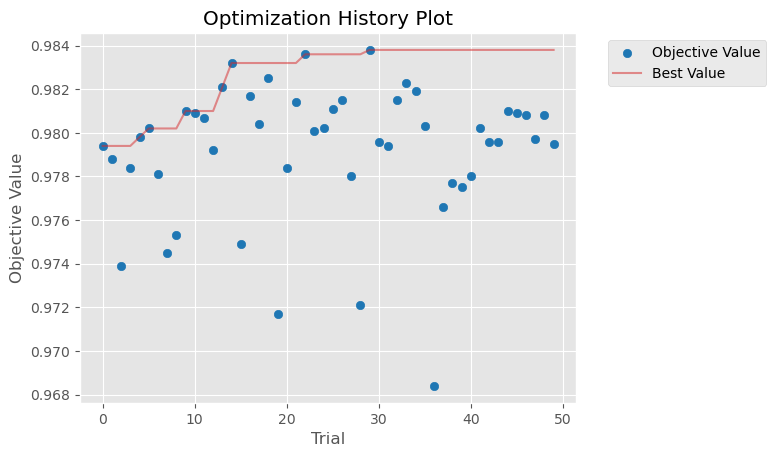

C:\Users\Clearlove\AppData\Local\Temp\ipykernel_23224\209955974.py:6: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


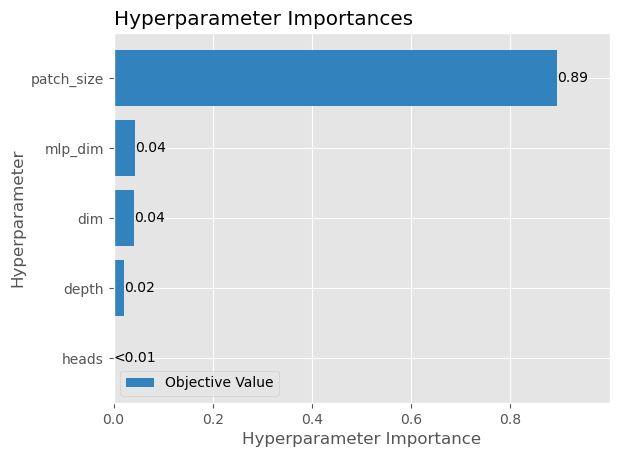

In [6]:
# 绘制优化历史
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

# 绘制超参数的重要性
optuna.visualization.matplotlib.plot_param_importances(study)*
plt.show()

In [17]:
# 使用最佳超参数创建模型
best_model = ViT(
    image_size=28, 
    patch_size=14, 
    num_classes=10, 
    dim=64, 
    depth=4, 
    heads=4, 
    mlp_dim=512, 
    channels=1
).to(device)

# 加载保存的最佳模型权重
best_model.load_state_dict(torch.load("best_model.pth"))

best_model.eval()
torch.cuda.synchronize()
model_cpu = best_model.cpu()
pred = model_cpu(mnist_test_dataset.data.unsqueeze(1).float() / 255.0)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')


Test accuracy: 0.9792
